## Some analysis of Delhi Pollution Data

The datasets for pollution data in many countries are readily available and there has been a bunch of research already done on those. I wanted to see if I could do some analysis of the pollution patterns of Indian cities. Unfortunately, I could not find an openly accessible historical pollution dataset for Indian cities. The folks over at [aqicn.org](http://aqicn.org) apparently provide access to institutions but not to individuals. In any case, I was able to locate a fantastic initiative by the [Delhi Pollution Control Committee](http://www.dpccairdata.com/dpccairdata/display/index.php). They provide *raw* pollution data from six sensor clusters inside the city. While the availability could be better, and all sensor clusters do not cover all the metrics, this kind of data is incredibly useful. Kudos to them for having made this available! One problem is that they do not provide historical data, so I had to aggregate the realtime data over time. What follows is some analysis of that data. Hopefully, as the dataset grows, we'd be able to derive more insights about the pollution situation in delhi.

EDIT: TERI has done some interesting analysis on the Odd-Even scheme based on data from DPCC and CPCB. This study is available [here](http://www.teriin.org/files/TERI-Analysis-Odd-even.pdf).

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import itertools

import re

%matplotlib inline

### Munging

The data I am dumping out into the csv file below is pretty raw. It look like:

In [5]:
rawdata = pd.read_csv('./netfile.csv', names=['location', 'metric', 'ts', 'reading', 'guidance'])
rawdata.sort_values(['ts', 'location'])
rawdata.head()

,location,metric,ts,reading,guidance
0,Punjabi Bagh,Ammonia,1471960200,19.1 µg/m3,400 µg/m3
1,Punjabi Bagh,Benzene,1471960200,0.2 µg/m3,05 µg/m3 *
2,Punjabi Bagh,Carbon Monoxide,1471960200,1.2 mg/m3,04 mg/m3
3,Punjabi Bagh,Nitrogen Dioxide,1471960200,49.6 µg/m3,80 µg/m3
4,Punjabi Bagh,Nitrogen Oxide,1471960200,4.3 µg/m3,-


In [6]:
rawdata.location.value_counts()

IGI Airport     15860
Anand Vihar     15067
Punjabi Bagh    15067
RK Puram        15067
Civil Lines      8723
Mandir Mark       532
Name: location, dtype: int64

In [7]:
rawdata.metric.value_counts()

Carbon Monoxide                                       3993
Nitrogen Oxide                                        3993
Toluene                                               3993
p-Xylene                                              3993
Benzene                                               3993
Ozone                                                 3993
Sulphur Dioxide                                       3993
Ammonia                                               3993
Nitrogen Dioxide                                      3993
Wind Direction                                        3200
Particulate Matter < 2.5 µg                           2407
Vertical Wind Speed                                   2407
Solar Radiation                                       2407
Oxides of Nitrogen                                    2407
Relative Humidity                                     2407
Ambient Temperature                                   2407
Barometric Pressure                                   24

Some of these metrics sound inferable: for example *Nitrogen Dioxide* and *Nitrogen Oxide* should give a good estimate for *Oxides of Nitrogen* where it does not exist independently. However, we'll look at that later. For now, let's munge this into a more useful dataframe

In [8]:
rawdata['ts'] = pd.to_datetime(rawdata.ts, unit='s')

def mungeReading(x):
    return "".join([t[0] for t in re.findall("[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?", x)][:1]) if not (x.strip() == '-') else "coerce"

rawdata['reading'] = pd.to_numeric(rawdata.reading.apply(mungeReading), errors='coerce')
rawdata['guidance'] = pd.to_numeric(rawdata.guidance.apply(mungeReading), errors='coerce')

rawdata.head()

,location,metric,ts,reading,guidance
0,Punjabi Bagh,Ammonia,2016-08-23 13:50:00,19.1,400.0
1,Punjabi Bagh,Benzene,2016-08-23 13:50:00,0.2,5.0
2,Punjabi Bagh,Carbon Monoxide,2016-08-23 13:50:00,1.2,4.0
3,Punjabi Bagh,Nitrogen Dioxide,2016-08-23 13:50:00,49.6,80.0
4,Punjabi Bagh,Nitrogen Oxide,2016-08-23 13:50:00,4.3,NaN


In [9]:
rawdata.reading.isnull().sum(), len(rawdata.reading), rawdata.guidance.isnull().sum(), len(rawdata.guidance)

(4196, 70316, 39580, 70316)

So that looks reasonable and only a few readings are NaN. I expect that the guidance is a simple function of the metric and should not change that often. Let us check:

In [10]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       3460
                                                   3.0          533
Benzene                                            5.0         3982
                                                   3.0           11
Carbon Monoxide                                    4.0         1764
                                                   3.0          643
Mass Concentration PM 10 (Previous Day's Average)  100.0        793
Nitrogen Dioxide                                   80.0        3453
                                                   3.0          540
Nitrogen Oxide                                     3.0          541
Oxides of Nitrogen                                 3.0          540
Ozone                                              180.0       3932
                                                   3.0           61
Particulate Matter < 10 µg                         100.0

Woah, loooks like there are multiple guidances per metric. For 9 records, the guidance for Ammonia, which ought to be 400 was listed as 3.0. Let us check those records..

In [11]:
rawdata[(rawdata['metric'] == 'Ammonia') & (rawdata['guidance'] == 3.0)]

,location,metric,ts,reading,guidance
6814,RK Puram,Ammonia,2016-08-24 09:15:00,3.0,3.0
15174,RK Puram,Ammonia,2016-08-25 09:05:00,3.0,3.0
15262,RK Puram,Ammonia,2016-08-25 09:25:00,3.0,3.0
15350,RK Puram,Ammonia,2016-08-25 09:30:00,3.0,3.0
15507,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
15595,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
15683,Anand Vihar,Ammonia,2016-08-25 10:15:00,3.0,3.0
23622,RK Puram,Ammonia,2016-08-26 09:10:00,3.0,3.0
23710,RK Puram,Ammonia,2016-08-26 09:30:00,3.0,3.0
25256,Punjabi Bagh,Ammonia,2016-08-26 13:45:00,3.0,3.0


In [12]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    111
Name: reading, dtype: int64

In [13]:
rawdata[(rawdata['metric'] == 'Sulphur Dioxide') & (rawdata['guidance'] == 3.0)]['reading'].value_counts()

3.0    747
Name: reading, dtype: int64

Looks like these are buggy readings, given that the guidance and reading both settle at 3.0, which clearly is an incorrect guidance for these particular metrics. I think that it is a good guess that all records with both guidance and readings at precisely 3.0 are spurious and should be dropped.

In [14]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 3.0) & (rawdata['reading'] != 3.0)]
rawdata.shape

(70316, 5)


(65964, 5)

In [15]:
rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['reading'] == 0.0)]

,location,metric,ts,reading,guidance
4765,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:15:00,0.0,0.0
4853,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:25:00,0.0,0.0
4941,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:45:00,0.0,0.0
5029,Punjabi Bagh,Particulate Matter < 2.5 µg,2016-08-24 03:55:00,0.0,0.0
13779,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:00:00,0.0,0.0
13867,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:10:00,0.0,0.0
13955,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:30:00,0.0,0.0
14043,RK Puram,Particulate Matter < 2.5 µg,2016-08-25 05:50:00,0.0,0.0


These zero guidance/readings also look incorrect. Lets drop these as well.

In [16]:
print(rawdata.shape)
rawdata = rawdata[(rawdata['guidance'] != 0.0) & (rawdata['reading'] != 0.0)]
rawdata.shape

(65964, 5)


(64045, 5)

In [17]:
rawdata[['metric', 'guidance']].groupby('metric').guidance.value_counts()

metric                                             guidance
Ammonia                                            400.0       3460
Benzene                                            5.0         3948
Carbon Monoxide                                    4.0         1732
Mass Concentration PM 10 (Previous Day's Average)  100.0        793
Nitrogen Dioxide                                   80.0        3453
Ozone                                              180.0       3929
Particulate Matter < 10 µg                         100.0       2292
Particulate Matter < 2.5 µg                        60.0        2151
Solar Radiation                                    2.0           12
Sulphur Dioxide                                    80.0        3240
Vertical Wind Speed                                0.1          135
                                                   0.2           48
                                                   0.3           16
                                                   0.4  

I think the data is cleaner now, and as we suspected, there is a single guidance per metric save for *Vertical Wind Speed*, which feels fairly reasonable. For other metrics, the guidance is NaN

In [18]:
rawdata = rawdata[['metric', 'location', 'reading', 'ts']]

### Some simple plots

Lets take our first look at the data for a few metrics.

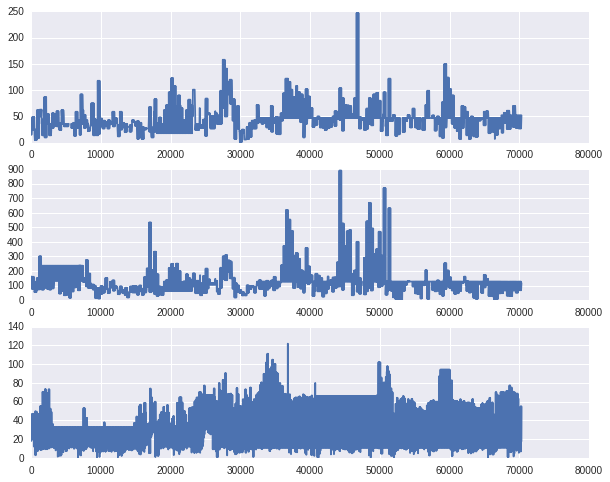

In [19]:
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(311)
ax1.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 2.5 µg']['reading'])
ax2 = fig.add_subplot(312)
ax2.plot(rawdata[rawdata['metric'] == 'Particulate Matter < 10 µg']['reading'])
ax2 = fig.add_subplot(313)
ax2.plot(rawdata[rawdata['metric'] == 'Ozone']['reading'])

I'd not have expected the peaks to add up to a constant value. There are large flat plateaus seem a bit strange to me, particularly given that this is aggregated data. Of course, the data for different stations is not synchronized from a timestamp perspective. Hence, it could be that the same readings occur at different stations but are staggered.

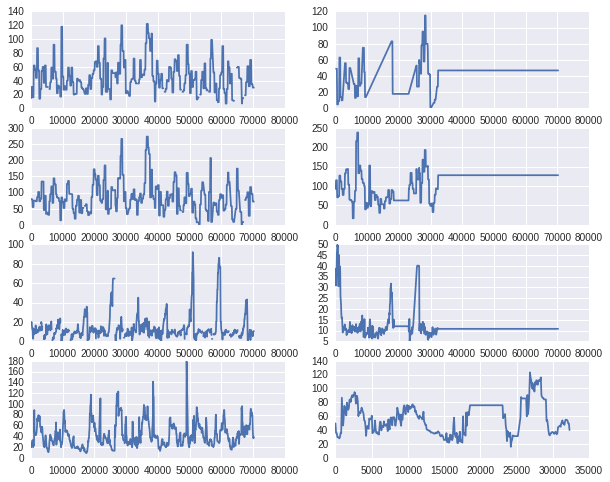

In [22]:
fig = plt.figure(figsize=(10,8))

ax1 = fig.add_subplot(421)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(423)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(425)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'RK Puram')]['reading'])
ax2 = fig.add_subplot(427)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'RK Puram')]['reading'])

ax1 = fig.add_subplot(422)
ax1.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 2.5 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(424)
ax2.plot(rawdata[(rawdata['metric'] == 'Particulate Matter < 10 µg') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(426)
ax2.plot(rawdata[(rawdata['metric'] == 'Ozone') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])
ax2 = fig.add_subplot(428)
ax2.plot(rawdata[(rawdata['metric'] == 'Nitrogen Dioxide') & (rawdata['location'] == 'Punjabi Bagh')]['reading'])

There seems to be some periodicity in the PM 10mcg plot for RK Puram, but that does not hold for Punjabi Bagh. I am surprised by the flat plateaus that are seen in some areas. Could be due to lack of readings in the middle. It is however strange that the Nitrogen Dioxide metric for Punjabi Bagh seems to be constant even after a significant time, particularly given how noisy it has been otherwise. Also, very interestingly, for *Punjabi Bagh*, the plateaus in the data at the very end stack up at the same time for all the metrics. Looks like some issue with the website as stale data might have been returned for a bunch of time.

In [23]:
def getReadings(metrics='all', location='all'):
    allReadings = []
    if location == 'all':
        rd = rawdata
    else:
        rd = rawdata[rawdata['location'] == location]
    if metrics == 'all':
        if location == 'all':
            metrics = list(set(list(rawdata['metric'])))
        else:
            metrics = list(set(list(rawdata[rawdata['location'] == location]['metric'])))
    for m in metrics:
        allReadings.append(np.array(rd[rd['metric'] == m]['reading']))
    #return pd.DataFrame(list(zip(allReadings))).transpose()
    t = pd.DataFrame(allReadings).transpose().dropna()
    t.columns = metrics
    return t

/home/rohit/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


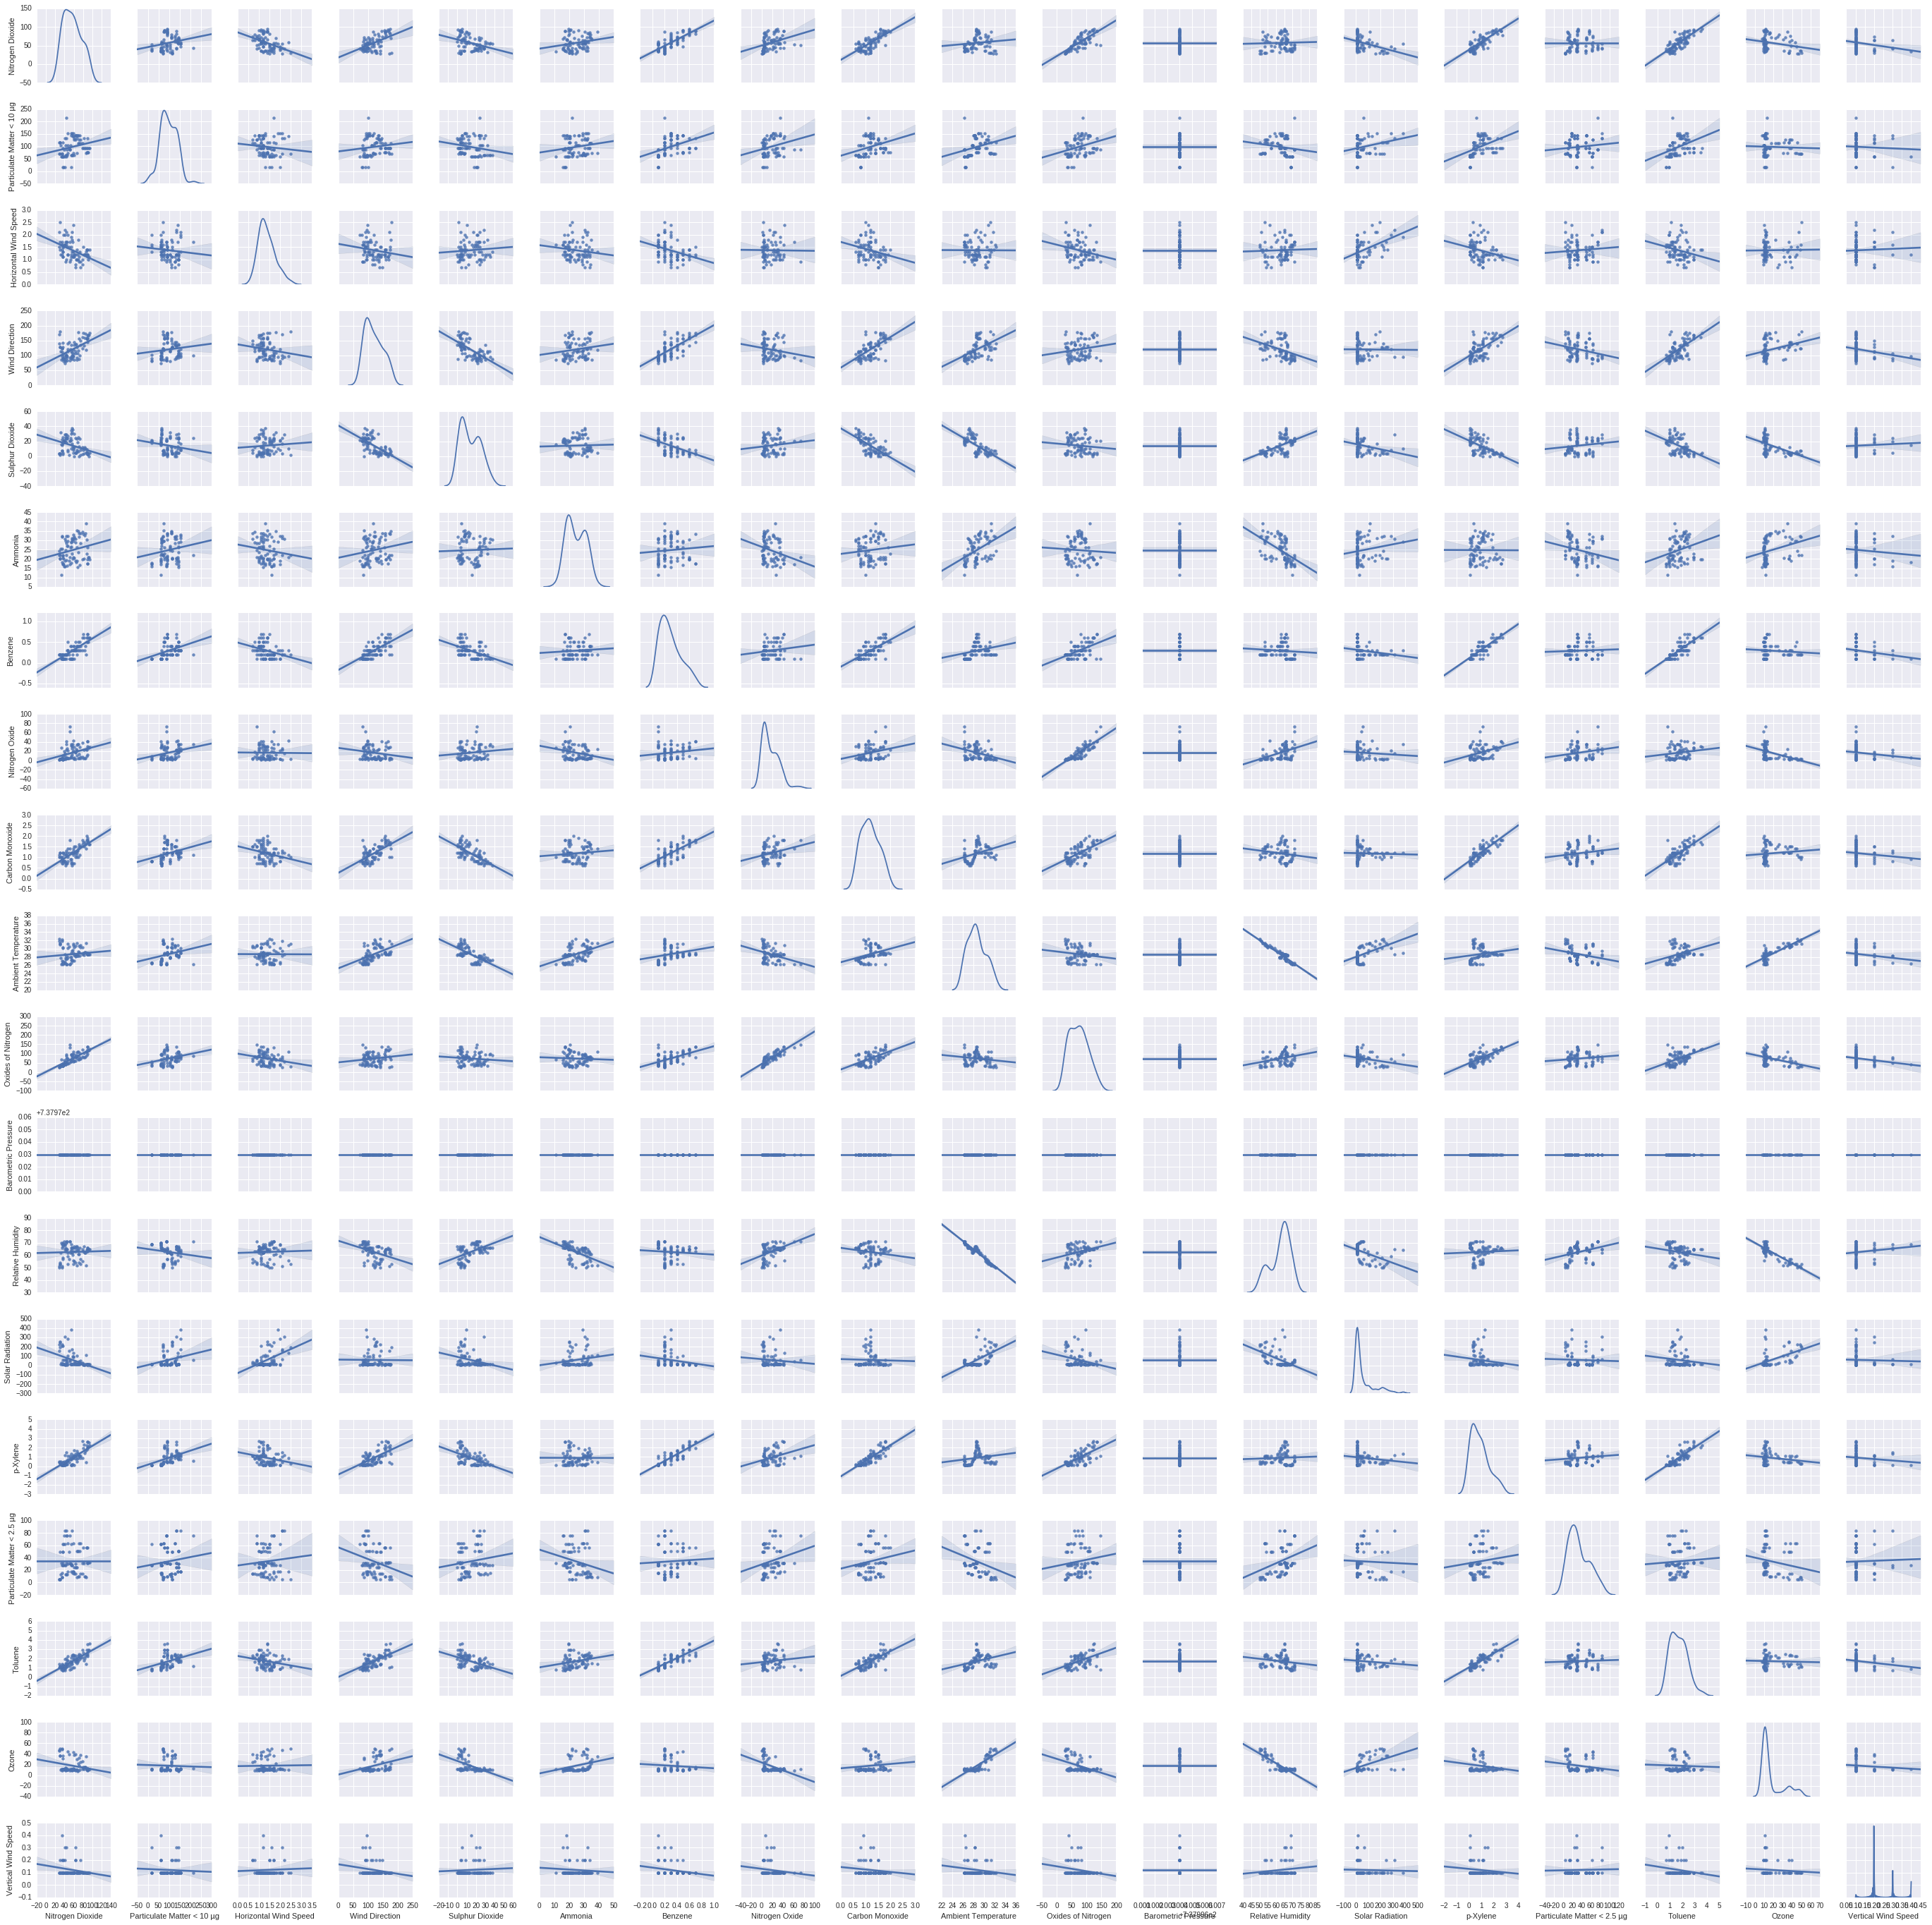

In [24]:
sn.pairplot(getReadings(location='Punjabi Bagh'), size=2, kind="reg", diag_kind="kde")

This pairplot has a wealth of information. Lets quickly note down those pairs with good linear estimators and low error ranges.

1. Ozone vs Relative Humidity
2. $CO$ vs p-Xylene
3. $NO_2$ and $NO$ vs Oxides of $N_2$ (Gives a sense of sanity)
4. Solar Radiation vs N-oxides (Non linear, but somewhat hyperbolic)
5. p-Xylene and Benzene
6. p-Xylene and N-oxides
7. p-Xylene and Toluene
8. Toluene and Benzene

/home/rohit/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


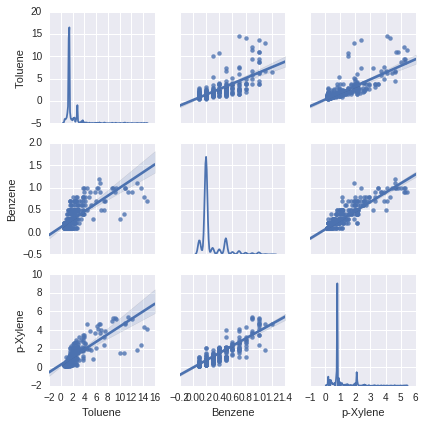

In [25]:
sn.pairplot(getReadings(metrics=['Toluene','Benzene', 'p-Xylene'], location='Punjabi Bagh'), size=2, kind="reg", diag_kind="kde")

Well, the linear relationship is fairly pronounced. Since all these contain the benzene ring, they might be well related as being emitted from the same sources. Interestingly, I think that we are seeing quantization in the *Benzene* values, suggesting that the sensor for that metric is imprecise. Just to confirm, lets check for another station.

/home/rohit/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


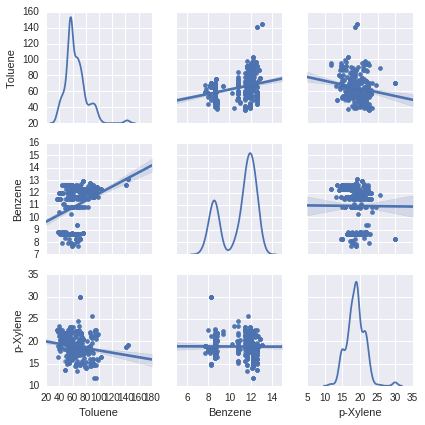

In [35]:
sn.pairplot(getReadings(metrics=['Toluene','Benzene', 'p-Xylene'], location='IGI Airport'), size=2, kind="reg", diag_kind="kde")

Well, there is no particularly linear relation here, so that correlation does not seem to hold up for all stations.

/home/rohit/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


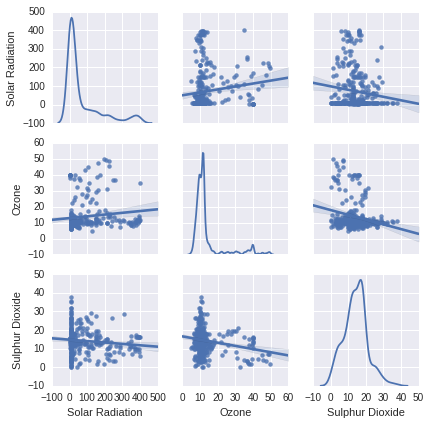

In [36]:
sn.pairplot(getReadings(metrics=['Solar Radiation','Ozone', 'Sulphur Dioxide'], location='Punjabi Bagh'), size=2, kind="reg", diag_kind="kde")

No clear pattern seems to be emerging for this. The hyperbolic curve that we saw earlier is still there, but very fuzzy.

In [37]:
def getCorrelatedMetrics(threshold, dframe, method='spearman'):
    df = dframe.corr(method)
    indices = np.where(df > threshold)
    indices = [(df.index[x], df.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
    return sorted([(t, df[t[1]][t[0]]) for t in indices], key=lambda x: x[1], reverse=True)

def getCommonMetrics(locations='all'):
    if locations == 'all':
        locations = list(set(list(rawdata['location'])))
    metricDict = {}
    for location in locations:
        metricDict[location] = set(rawdata[rawdata['location'] == location]['metric'])
    commonMetrics = set.intersection(*metricDict.values())
    return commonMetrics

In [38]:
getCommonMetrics()

{'Ammonia',
 'Benzene',
 'Carbon Monoxide',
 'Nitrogen Dioxide',
 'Nitrogen Oxide',
 'Ozone',
 'Sulphur Dioxide',
 'Toluene',
 'p-Xylene'}

In [39]:
getCorrelatedMetrics(0.5, getReadings(location='RK Puram'))

[(('Nitrogen Dioxide', 'Oxides of Nitrogen'), 0.88248646505046946),
 (('Oxides of Nitrogen', 'Toluene'), 0.84137035895797097),
 (('Nitrogen Oxide', 'Oxides of Nitrogen'), 0.79454417713882564),
 (('Nitrogen Dioxide', 'Toluene'), 0.73663706476607849),
 (('Nitrogen Oxide', 'Toluene'), 0.7091167648884672),
 (('Carbon Monoxide', 'Oxides of Nitrogen'), 0.6682397115849521),
 (('Carbon Monoxide', 'Toluene'), 0.66249490238540576),
 (('Benzene', 'Toluene'), 0.65614313301372085),
 (('Nitrogen Oxide', 'Carbon Monoxide'), 0.62893087125524993),
 (('Benzene', 'Oxides of Nitrogen'), 0.60652901223471345),
 (('Nitrogen Dioxide', 'Nitrogen Oxide'), 0.59720274632450054),
 (('Nitrogen Dioxide', 'Carbon Monoxide'), 0.57407829453611858),
 (('Benzene', 'Relative Humidity'), 0.56670572510907147),
 (('Particulate Matter < 10 µg', 'Particulate Matter < 2.5 µg'),
  0.55692144577565827),
 (('Particulate Matter < 10 µg', 'Benzene'), 0.51944316177389094)]

In [40]:
getCorrelatedMetrics(0.5, getReadings(location='Punjabi Bagh'))

[(('Nitrogen Oxide', 'Oxides of Nitrogen'), 0.89573482457654474),
 (('Carbon Monoxide', 'p-Xylene'), 0.85794345138556194),
 (('Benzene', 'p-Xylene'), 0.85253315006092345),
 (('Benzene', 'Toluene'), 0.8374989915357941),
 (('p-Xylene', 'Toluene'), 0.82625026777817601),
 (('Nitrogen Dioxide', 'Oxides of Nitrogen'), 0.80607902107524543),
 (('Nitrogen Dioxide', 'Toluene'), 0.78061158539924735),
 (('Nitrogen Dioxide', 'p-Xylene'), 0.74639208843655203),
 (('Nitrogen Dioxide', 'Benzene'), 0.73212454312962572),
 (('Carbon Monoxide', 'Toluene'), 0.71151271331744326),
 (('Wind Direction', 'Benzene'), 0.67244931253289641),
 (('Nitrogen Dioxide', 'Carbon Monoxide'), 0.66894498181185913),
 (('Benzene', 'Carbon Monoxide'), 0.66638085988636231),
 (('Ambient Temperature', 'Ozone'), 0.62509333015871626),
 (('Wind Direction', 'Toluene'), 0.61517499469671599),
 (('Oxides of Nitrogen', 'p-Xylene'), 0.60968444186188842),
 (('Particulate Matter < 10 µg', 'p-Xylene'), 0.60823901928092639),
 (('Wind Direction'

In [42]:
getCorrelatedMetrics(0.1, getReadings(metrics=getCommonMetrics()))

[(('Nitrogen Dioxide', 'Nitrogen Oxide'), 0.36325430316888846),
 (('Carbon Monoxide', 'p-Xylene'), 0.1827729420627397),
 (('p-Xylene', 'Toluene'), 0.15965548576378266),
 (('Nitrogen Oxide', 'Toluene'), 0.14784790357631666),
 (('Nitrogen Oxide', 'Benzene'), 0.12288887016406209),
 (('Benzene', 'Toluene'), 0.11833457617840676),
 (('Nitrogen Dioxide', 'Benzene'), 0.10742530642903757),
 (('Nitrogen Oxide', 'Ozone'), 0.10235683265366288)]

Well, atleast the Nitrogen oxides are significantly correlated across all stations, even if I'd have expected that correlationship to be stronger. This needs to be checked further.

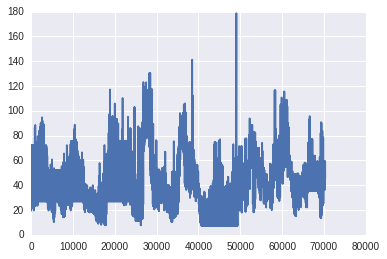

In [43]:
plt.plot(rawdata[rawdata['metric'] == 'Nitrogen Dioxide']['reading'])